In [1]:
# Import library
import requests, zipfile, shutil, os
requests.packages.urllib3.disable_warnings()
# import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.models import Sequential
# from tensorflow.keras import layers, models, optimizers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


2023-11-25 03:52:22.756368: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 03:52:26.699083: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-11-25 03:52:26.699310: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: 

In [2]:
# Define the URL to download the dataset #https://www.muratkoklu.com/datasets/
dataset_url = "https://www.muratkoklu.com/datasets/vtdhnd12.php"

# Download the dataset to a temporary file
response = requests.get(dataset_url)
with open("pistachio_dataset.zip", "wb") as f:
    f.write(response.content)

# Extract the dataset from the ZIP file
with zipfile.ZipFile("pistachio_dataset.zip", "r") as zip_ref:
    zip_ref.extractall()

# Delete the temporary ZIP file
os.remove("pistachio_dataset.zip")

# Define the source directories for the downloaded images
kirmizi_dir = "./Pistachio_Image_Dataset/Pistachio_Image_Dataset/Kirmizi_Pistachio/"
siirt_dir = "./Pistachio_Image_Dataset/Pistachio_Image_Dataset/Siirt_Pistachio/"

# Define the directories for train, test, and validation sets for both categories
train_dir_kirmizi = "./Pistachio_Image_Dataset/Pistachio_Image_Dataset/train/kirmizi"
test_dir_kirmizi = "./Pistachio_Image_Dataset/Pistachio_Image_Dataset/test/kirmizi"
validation_dir_kirmizi = "./Pistachio_Image_Dataset/Pistachio_Image_Dataset/validation/kirmizi"

train_dir_siirt = "./Pistachio_Image_Dataset/Pistachio_Image_Dataset/train/siirt"
test_dir_siirt = "./Pistachio_Image_Dataset/Pistachio_Image_Dataset/test/siirt"
validation_dir_siirt = "./Pistachio_Image_Dataset/Pistachio_Image_Dataset/validation/siirt"

# Create directories for train, test, and validation sets for both categories
for directory in [train_dir_kirmizi, test_dir_kirmizi, validation_dir_kirmizi,
                  train_dir_siirt, test_dir_siirt, validation_dir_siirt]:
    if not os.path.exists(directory):
        os.makedirs(directory)

# Define the number of images to copy for each set
train_images = 70
test_images = 10
validation_images = 20

# Copy Kirmizi images
kirmizi_image_files = os.listdir(kirmizi_dir)
np.random.shuffle(kirmizi_image_files)

# Train set
for i in range(train_images):
    source_path = os.path.join(kirmizi_dir, kirmizi_image_files[i])
    destination_path = os.path.join("./Pistachio_Image_Dataset/Pistachio_Image_Dataset/train/kirmizi/", kirmizi_image_files[i])
    shutil.copy2(source_path, destination_path)

# Test set
for i in range(train_images, train_images + test_images):
    source_path = os.path.join(kirmizi_dir, kirmizi_image_files[i])
    destination_path = os.path.join("./Pistachio_Image_Dataset/Pistachio_Image_Dataset/test/kirmizi/", kirmizi_image_files[i])
    shutil.copy2(source_path, destination_path)

# Validation set
for i in range(train_images + test_images, train_images + test_images + validation_images):
    source_path = os.path.join(kirmizi_dir, kirmizi_image_files[i])
    destination_path = os.path.join("./Pistachio_Image_Dataset/Pistachio_Image_Dataset/validation/kirmizi/", kirmizi_image_files[i])
    shutil.copy2(source_path, destination_path)

# Copy Siirt images
siirt_image_files = os.listdir(siirt_dir)
np.random.shuffle(siirt_image_files)

# Train set
for i in range(train_images):
    source_path = os.path.join(siirt_dir, siirt_image_files[i])
    destination_path = os.path.join("./Pistachio_Image_Dataset/Pistachio_Image_Dataset/train/siirt/", siirt_image_files[i])
    shutil.copy2(source_path, destination_path)

# Test set
for i in range(train_images, train_images + test_images):
    source_path = os.path.join(siirt_dir, siirt_image_files[i])
    destination_path = os.path.join("./Pistachio_Image_Dataset/Pistachio_Image_Dataset/test/siirt/", siirt_image_files[i])
    shutil.copy2(source_path, destination_path)

# Validation set
for i in range(train_images + test_images, train_images + test_images + validation_images):
    source_path = os.path.join(siirt_dir, siirt_image_files[i])
    destination_path = os.path.join("./Pistachio_Image_Dataset/Pistachio_Image_Dataset/validation/siirt/", siirt_image_files[i])
    shutil.copy2(source_path, destination_path)

In [3]:
# Define the path to the downloaded dataset
train_dir = "./Pistachio_Image_Dataset/Pistachio_Image_Dataset/train/"
test_dir = "./Pistachio_Image_Dataset/Pistachio_Image_Dataset/test/"
validation_dir = "./Pistachio_Image_Dataset/Pistachio_Image_Dataset/validation/"


# Image data preprocessing
images = []
labels = []

# Iterate over the Kirmizi images and add them to the arrays
for filename in os.listdir(kirmizi_dir):
    image = Image.open(os.path.join(kirmizi_dir, filename))
    image = image.resize((128, 128))  # Resize the image to 128x128
    image = np.array(image) / 255.0  # Normalize pixel values to range [0, 1]
    images.append(image)
    labels.append(0)  # Label Kirmizi as 0

# Iterate over the Siirt images and add them to the arrays
for filename in os.listdir(siirt_dir):
    image = Image.open(os.path.join(siirt_dir, filename))
    image = image.resize((128, 128))  # Resize the image to 128x128
    image = np.array(image) / 255.0  # Normalize pixel values to range [0, 1]
    images.append(image)
    labels.append(1)  # Label Siirt as 1

# Initialize empty NumPy arrays to store the image data and labels
images = []
labels = []

# Iterate over the Kirmizi images and add them to the arrays
for filename in os.listdir(train_dir_kirmizi):
    image = Image.open(os.path.join(train_dir_kirmizi, filename))
    images.append(np.array(image))
    labels.append(0)  # Label Kirmizi as 0

# Iterate over the Siirt images and add them to the arrays
for filename in os.listdir(train_dir_siirt):
    image = Image.open(os.path.join(train_dir_siirt, filename))
    images.append(np.array(image))
    labels.append(1)  # Label Siirt as 1

# Convert the lists to NumPy arrays
images = np.array(images)
labels = np.array(labels)

# Print the shapes of the image and labels arrays
print("Images shape:", images.shape)
print("Labels shape:", labels.shape)

# Split the data into training and testing sets
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=77)

# Print the shapes of the training and testing sets
print("Training images shape:", train_images.shape)
print("Training labels shape:", train_labels.shape)
print("Testing images shape:", test_images.shape)
print("Testing labels shape:", test_labels.shape)

Images shape: (398, 600, 600, 3)
Labels shape: (398,)
Training images shape: (318, 600, 600, 3)
Training labels shape: (318,)
Testing images shape: (80, 600, 600, 3)
Testing labels shape: (80,)


In [ ]:
# param_grid={'C':[0.1,1,10,100],'gamma':[0.0001,0.001,0.1,1],'kernel':['rbf','poly']}
# svc=svm.SVC(probability=True)
# model=GridSearchCV(svc,param_grid)

# Initialize and train the SVM model
param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [0.0001, 0.001, 0.1, 1], 'kernel': ['rbf', 'poly']}
svc = svm.SVC(probability=True)
model = GridSearchCV(svc, param_grid)

# Flatten the training images to match SVM input requirements
train_images_flattened = train_images.reshape(train_images.shape[0], -1)

model.fit(train_images_flattened, train_labels)

# Flatten the test images for prediction
test_images_flattened = test_images.reshape(test_images.shape[0], -1)

test_prediction = model.predict(test_images_flattened)
accuracy = accuracy_score(test_prediction, test_labels)
print(f"The model is {accuracy * 100:.2f}% accurate")


In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Calculate the confusion matrix
conf_matrix = confusion_matrix(test_labels, test_prediction)

# Plot the confusion matrix as a graph
plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
plt.colorbar()

classes = ['Kirmizi', 'Siirt']
tick_marks = np.arange(len(classes))

plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, str(conf_matrix[i][j]), horizontalalignment='center', color='black')

plt.show()


# from sklearn.metrics import confusion_matrix
# import seaborn as sns

# # Calculate the confusion matrix
# conf_matrix = confusion_matrix(test_labels, test_prediction)

# # Plot the confusion matrix as a heatmap
# plt.figure(figsize=(8, 6))
# sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', 
#             xticklabels=['Kirmizi', 'Siirt'], 
#             yticklabels=['Kirmizi', 'Siirt'])
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.title('Confusion Matrix')
# plt.show()

In [ ]:
# import os

# # Define the paths for Kirmizi and Siirt images
# # kirmizi_dir = "./Pistachio_Image_Dataset/Pistachio_Image_Dataset/train/kirmizi/"
# # siirt_dir = "./Pistachio_Image_Dataset/Pistachio_Image_Dataset/train/siirt/"

# # kirmizi_dir = "./Pistachio_Image_Dataset/Pistachio_Image_Dataset/Kirmizi_Pistachio/"
# # siirt_dir = "./Pistachio_Image_Dataset/Pistachio_Image_Dataset/Siirt_Pistachio/"

# # Define the directories for train, test, and validation sets for both categories
# train_dir_kirmizi = "./Pistachio_Image_Dataset/Pistachio_Image_Dataset/train/kirmizi"
# # test_dir_kirmizi = "./Pistachio_Image_Dataset/Pistachio_Image_Dataset/test/kirmizi"
# # validation_dir_kirmizi = "./Pistachio_Image_Dataset/Pistachio_Image_Dataset/validation/kirmizi"

# train_dir_siirt = "./Pistachio_Image_Dataset/Pistachio_Image_Dataset/train/siirt"
# # test_dir_siirt = "./Pistachio_Image_Dataset/Pistachio_Image_Dataset/test/siirt"
# # validation_dir_siirt = "./Pistachio_Image_Dataset/Pistachio_Image_Dataset/validation/siirt"



# # Collect Kirmizi image paths
# kirmizi_images = [os.path.join(train_dir_kirmizi, file) for file in os.listdir(train_dir_kirmizi) if file.endswith('.jpg')]

# # Collect Siirt image paths
# siirt_images = [os.path.join(train_dir_siirt, file) for file in os.listdir(train_dir_siirt) if file.endswith('.jpg')]

# # Create a list with all image paths and labels
# all_images = kirmizi_images + siirt_images
# labels = [0] * len(kirmizi_images) + [1] * len(siirt_images)  # Assuming Kirmizi is labeled as 0 and Siirt as 1


# # Split the data into training and testing sets
# train_image_paths, test_image_paths, train_labels, test_labels = train_test_split(
#     all_images, labels, test_size=0.2, random_state=77)

# model.fit(train_image_paths, train_labels)



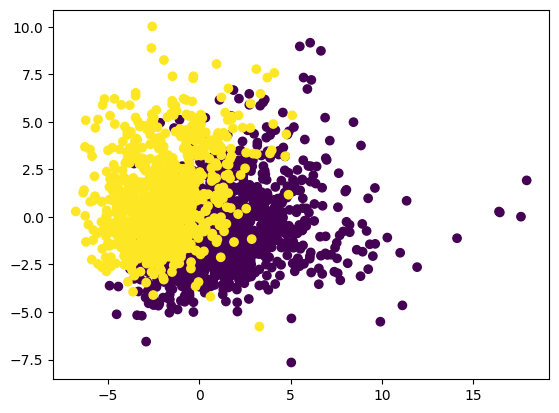

Modello = DecisioneTreeClassifier
DecisionTreeClassifier(max_depth=1000, random_state=42)
Accuracy train = 1.0,loss train = 2.2204460492503136e-16, errors train = 0 out of 1611
Accuracy test = 0.8715083798882681,loss test = 4.631307418713377, errors test = 69 out of 537
Training time = 0.09450554847717285s

Modello = RandomForestClassifier
RandomForestClassifier(max_depth=1000, random_state=42)
Accuracy train = 1.0,loss train = 0.07077741245715309, errors train = 0 out of 1611
Accuracy test = 0.9013035381750466,loss test = 0.2626092313801959, errors test = 53 out of 537
Training time = 1.008704662322998s

Modello = LogisticRegression
LogisticRegression(max_iter=1000, random_state=42)
Accuracy train = 0.9236499068901304,loss train = 0.1873289296246619, errors train = 123 out of 1611
Accuracy test = 0.9273743016759777,loss test = 0.16100020602862028, errors test = 39 out of 537
Training time = 0.10047292709350586s

Modello = SVC
SVC(probability=True, random_state=42)
Accuracy train = 0.9

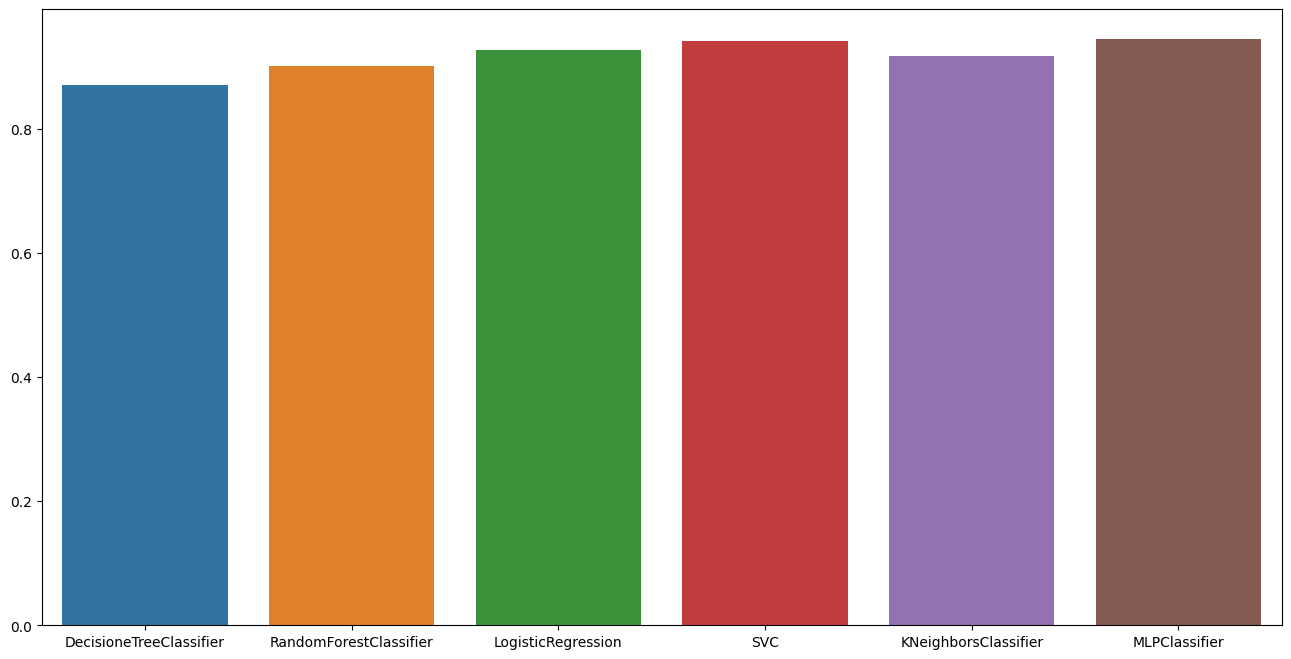

In [2]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns

!pip install openpyxl

data = pd.read_excel("./Pistachio_28_Features_Dataset.xlsx")
X = data.drop(columns='Class')
y = data['Class']
X,y

from sklearn.preprocessing import LabelEncoder,StandardScaler
encoder = LabelEncoder()
y = encoder.fit_transform(y)

scaler = StandardScaler()
X = scaler.fit_transform(X)


from sklearn.decomposition import PCA

model_PCA = PCA(n_components=2)
X_pca = model_PCA.fit_transform(X)
plt.scatter(X_pca[:,0],X_pca[:,1],c=y,cmap='viridis')
plt.show()


from sklearn.metrics import accuracy_score,log_loss

def count_error(y_true,y_pred):
    err = 0
    for i in range(len(y_true)):
        if(y_true[i]!=y_pred[i]): err+=1
    return err


from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

list_model = np.array([]); str_model = np.array(['DecisioneTreeClassifier','RandomForestClassifier','LogisticRegression','SVC','KNeighborsClassifier','MLPClassifier'])

list_model = np.append(list_model, DecisionTreeClassifier(max_depth=1000, criterion='gini',random_state=42))
list_model = np.append(list_model, RandomForestClassifier(n_estimators=100, max_depth=1000, criterion='gini',random_state=42))
list_model = np.append(list_model, LogisticRegression(max_iter=1000,random_state=42))
list_model = np.append(list_model, SVC(kernel='rbf', probability=True, degree=3,random_state=42))
list_model = np.append(list_model, KNeighborsClassifier(n_neighbors=10))
list_model = np.append(list_model, MLPClassifier(hidden_layer_sizes=(100,),learning_rate_init=0.01,max_iter=400,tol=0.0001,random_state=42))


from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=42)
accuracy_array = np.array([])

for i in range(len(list_model)):
    print(f"Modello = {str_model[i]}")
    start_time = time.time()
    print(list_model[i])
    list_model[i].fit(X_train,y_train)

    pred_Train = list_model[i].predict(X_train)
    pred_proba_Train = list_model[i].predict_proba(X_train)
    pred_Test = list_model[i].predict(X_test)
    pred_proba_Test = list_model[i].predict_proba(X_test)
    
    acc_test = accuracy_score(y_test, pred_Test)
    accuracy_array = np.append(accuracy_array,acc_test)
    print(f"Accuracy train = {accuracy_score(y_train, pred_Train)},loss train = {log_loss(y_train, pred_proba_Train)}, errors train = {count_error(y_train, pred_Train)} out of {len(y_train)}")
    print(f"Accuracy test = {acc_test},loss test = {log_loss(y_test, pred_proba_Test)}, errors test = {count_error(y_test, pred_Test)} out of {len(y_test)}")
    print(f"Training time = {time.time()-start_time}s")
    print()    
    
    
    
plt.figure(figsize=(16,8))
sns.barplot(x=str_model,y=accuracy_array)
plt.show()



Accuracy: 0.95
                   precision    recall  f1-score   support

Kirmizi_Pistachio       0.96      0.94      0.95       244
  Siirt_Pistachio       0.93      0.95      0.94       186

         accuracy                           0.95       430
        macro avg       0.94      0.95      0.95       430
     weighted avg       0.95      0.95      0.95       430



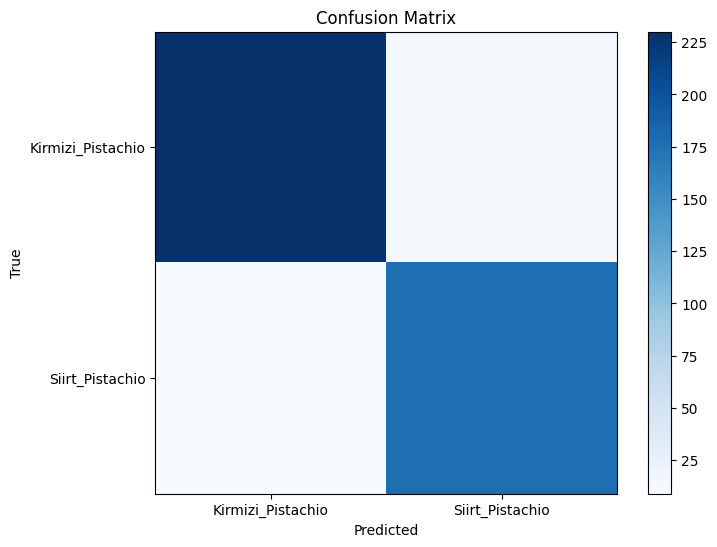

ModuleNotFoundError: No module named 'mlxtend'

In [8]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns

!pip install openpyxl

data = pd.read_excel("./Pistachio_28_Features_Dataset.xlsx")
X = data.drop(columns='Class')
y = data['Class']
X,y




from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

# Assuming you've already loaded and preprocessed your data
# X contains the features and y contains the target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the SVM classifier
svm = SVC(kernel='rbf', random_state=42)  # You can choose different kernels like 'linear', 'rbf', etc.

# Train the SVM classifier
svm.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = svm.predict(X_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Generate classification report
print(classification_report(y_test, y_pred))

# from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
# from mlxtend.plotting import plot_decision_regions  # For plotting decision boundary


cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y)))
plt.xticks(tick_marks, np.unique(y))
plt.yticks(tick_marks, np.unique(y))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()




In [ ]:
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split


def load_image(image_path):
    image = Image.open(image_path)
    # Convert image to RGB or grayscale (if needed)
    image = image.convert('RGB')
    # Resize image to a fixed size (if needed)
    image = image.resize((224, 224))
    # Convert image to NumPy array
    image_array = np.array(image)
    return image_array

# Load image data from directories
train_images = []
train_labels = []
for image_path in os.listdir('train'):
    label = os.path.basename(image_path).split('_')[0]  # Extract label from filename
    image_array = load_image(os.path.join('train', image_path))
    train_images.append(image_array)
    train_labels.append(label)

# Split data into training, testing, and validation sets
X_train, X_test, y_train, y_test = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

from sklearn.svm import SVC

# Create and train SVM classifier
svm_classifier = SVC(kernel='rbf', C=1.0)
svm_classifier.fit(X_train, y_train)


from sklearn.metrics import accuracy_score

# Evaluate model performance on test set
test_predictions = svm_classifier.predict(X_test)
test_accuracy = accuracy_score(y_test, test_predictions)
print('Test Accuracy:', test_accuracy)


In [1]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split

def load_image(image_path):
    image = Image.open(image_path)
    # Convert image to RGB or grayscale (if needed)
    image = image.convert('RGB')
    # Resize image to a fixed size (if needed)
    image = image.resize((224, 224))
    # Convert image to NumPy array
    image_array = np.array(image)
    return image_array.flatten()  # Flatten the image array

# Load image data from directories
image_directory = './Pistachio_Image_Dataset/Pistachio_Image_Dataset/Kirmizi_Pistachio/'
train_images = []
train_labels = []
for image_filename in os.listdir(image_directory):
    label = image_filename.split('_')[0]  # Extract label from filename
    image_path = os.path.join(image_directory, image_filename)
    image_array = load_image(image_path)
    train_images.append(image_array)
    train_labels.append(label)

# Split data into training, testing, and validation sets
X_train, X_test, y_train, y_test = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

from sklearn.svm import SVC

# Create and train SVM classifier
svm_classifier = SVC(kernel='rbf', C=1.0)
svm_classifier.fit(X_train, y_train)

from sklearn.metrics import accuracy_score

# Evaluate model performance on test set
test_predictions = svm_classifier.predict(X_test)
test_accuracy = accuracy_score(y_test, test_predictions)
print('Test Accuracy:', test_accuracy)


Test Accuracy: 0.0


Images shape: (391, 128, 128, 3)
Labels shape: (391,)
Training images shape: (312, 128, 128, 3)
Training labels shape: (312,)
Testing images shape: (79, 128, 128, 3)
Testing labels shape: (79,)


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 77.22%


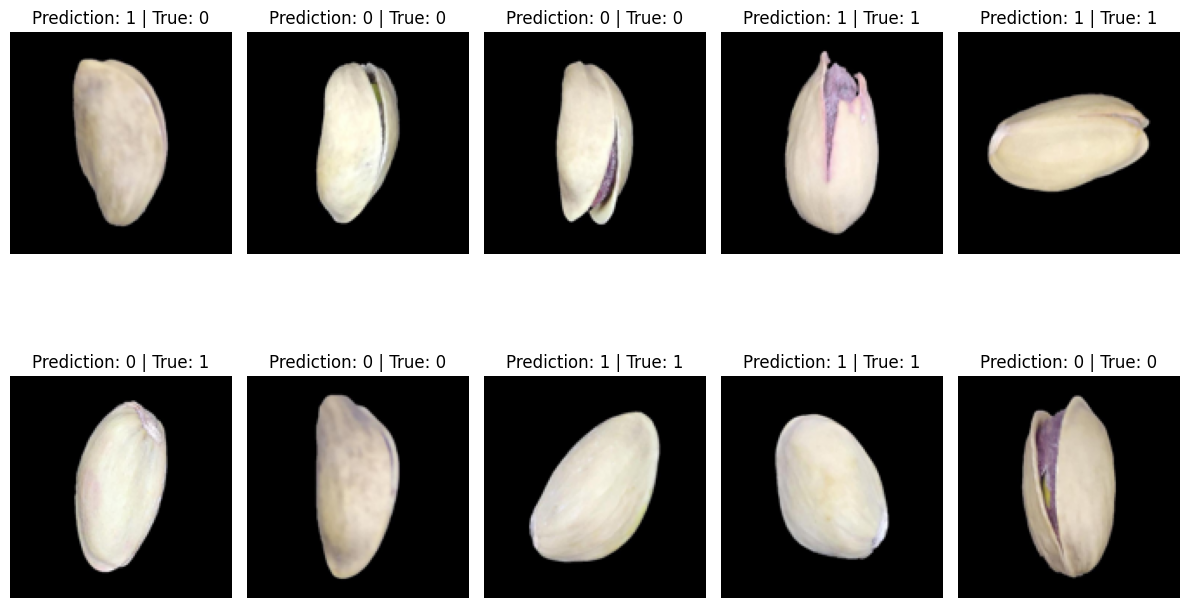

Epoch 1/10
8/8 [==============================] - 1s 35ms/step - loss: 0.6806 - accuracy: 0.5863 - val_loss: 0.6740 - val_accuracy: 0.4603
Epoch 2/10
8/8 [==============================] - 0s 13ms/step - loss: 0.6491 - accuracy: 0.5622 - val_loss: 0.6427 - val_accuracy: 0.5714
Epoch 3/10
8/8 [==============================] - 0s 13ms/step - loss: 0.6188 - accuracy: 0.6466 - val_loss: 0.6175 - val_accuracy: 0.6349
Epoch 4/10
8/8 [==============================] - 0s 15ms/step - loss: 0.5911 - accuracy: 0.7189 - val_loss: 0.5874 - val_accuracy: 0.6508
Epoch 5/10
8/8 [==============================] - 0s 15ms/step - loss: 0.5651 - accuracy: 0.7671 - val_loss: 0.5636 - val_accuracy: 0.6984
Epoch 6/10
8/8 [==============================] - 0s 14ms/step - loss: 0.5403 - accuracy: 0.7751 - val_loss: 0.5462 - val_accuracy: 0.6984
Epoch 7/10
8/8 [==============================] - 0s 13ms/step - loss: 0.5168 - accuracy: 0.7912 - val_loss: 0.5189 - val_accuracy: 0.7937
Epoch 8/10
8/8 [===========

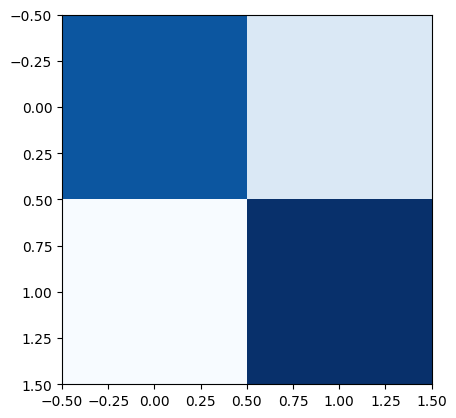

In [7]:
## Neural Network Models for Combined Classification and Regression

# Import library
import requests, zipfile, shutil, os
requests.packages.urllib3.disable_warnings()
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Define the URL to download the dataset #https://www.muratkoklu.com/datasets/
dataset_url = "https://www.muratkoklu.com/datasets/vtdhnd12.php"

# Download the dataset to a temporary file
response = requests.get(dataset_url)
with open("pistachio_dataset.zip", "wb") as f:
    f.write(response.content)

# Extract the dataset from the ZIP file
with zipfile.ZipFile("pistachio_dataset.zip", "r") as zip_ref:
    zip_ref.extractall()

# Delete the temporary ZIP file
os.remove("pistachio_dataset.zip")

# Define the source directories for the downloaded images
kirmizi_dir = "./Pistachio_Image_Dataset/Pistachio_Image_Dataset/Kirmizi_Pistachio/"
siirt_dir = "./Pistachio_Image_Dataset/Pistachio_Image_Dataset/Siirt_Pistachio/"


# Define the directories for train, test, and validation sets for both categories
train_dir_kirmizi = "./Pistachio_Image_Dataset/Pistachio_Image_Dataset/train/kirmizi"
test_dir_kirmizi = "./Pistachio_Image_Dataset/Pistachio_Image_Dataset/test/kirmizi"
validation_dir_kirmizi = "./Pistachio_Image_Dataset/Pistachio_Image_Dataset/validation/kirmizi"

train_dir_siirt = "./Pistachio_Image_Dataset/Pistachio_Image_Dataset/train/siirt"
test_dir_siirt = "./Pistachio_Image_Dataset/Pistachio_Image_Dataset/test/siirt"
validation_dir_siirt = "./Pistachio_Image_Dataset/Pistachio_Image_Dataset/validation/siirt"


# Create directories for train, test, and validation sets for both categories
for directory in [train_dir_kirmizi, test_dir_kirmizi, validation_dir_kirmizi,
                  train_dir_siirt, test_dir_siirt, validation_dir_siirt]:
    if not os.path.exists(directory):
        os.makedirs(directory)

# Define the number of images to copy for each set
train_images = 70
test_images = 10
validation_images = 20

# Copy Kirmizi images
kirmizi_image_files = os.listdir(kirmizi_dir)
np.random.shuffle(kirmizi_image_files)

# Train set
for i in range(train_images):
    source_path = os.path.join(kirmizi_dir, kirmizi_image_files[i])
    destination_path = os.path.join("./Pistachio_Image_Dataset/Pistachio_Image_Dataset/train/kirmizi/", kirmizi_image_files[i])
    shutil.copy2(source_path, destination_path)

# Test set
for i in range(train_images, train_images + test_images):
    source_path = os.path.join(kirmizi_dir, kirmizi_image_files[i])
    destination_path = os.path.join("./Pistachio_Image_Dataset/Pistachio_Image_Dataset/test/kirmizi/", kirmizi_image_files[i])
    shutil.copy2(source_path, destination_path)

# Validation set
for i in range(train_images + test_images, train_images + test_images + validation_images):
    source_path = os.path.join(kirmizi_dir, kirmizi_image_files[i])
    destination_path = os.path.join("./Pistachio_Image_Dataset/Pistachio_Image_Dataset/validation/kirmizi/", kirmizi_image_files[i])
    shutil.copy2(source_path, destination_path)

# Copy Siirt images
siirt_image_files = os.listdir(siirt_dir)
np.random.shuffle(siirt_image_files)

# Train set
for i in range(train_images):
    source_path = os.path.join(siirt_dir, siirt_image_files[i])
    destination_path = os.path.join("./Pistachio_Image_Dataset/Pistachio_Image_Dataset/train/siirt/", siirt_image_files[i])
    shutil.copy2(source_path, destination_path)

# Test set
for i in range(train_images, train_images + test_images):
    source_path = os.path.join(siirt_dir, siirt_image_files[i])
    destination_path = os.path.join("./Pistachio_Image_Dataset/Pistachio_Image_Dataset/test/siirt/", siirt_image_files[i])
    shutil.copy2(source_path, destination_path)

# Validation set
for i in range(train_images + test_images, train_images + test_images + validation_images):
    source_path = os.path.join(siirt_dir, siirt_image_files[i])
    destination_path = os.path.join("./Pistachio_Image_Dataset/Pistachio_Image_Dataset/validation/siirt/", siirt_image_files[i])
    shutil.copy2(source_path, destination_path)

# Define the path to the downloaded dataset
train_dir = "./Pistachio_Image_Dataset/Pistachio_Image_Dataset/train/"
test_dir = "./Pistachio_Image_Dataset/Pistachio_Image_Dataset/test/"
validation_dir = "./Pistachio_Image_Dataset/Pistachio_Image_Dataset/validation/"

# # Iterate over the Kirmizi images and add them to the arrays
# for filename in os.listdir(kirmizi_dir):
#     image = Image.open(os.path.join(kirmizi_dir, filename))
#     image = image.resize((128, 128))  # Resize the image to 128x128
#     image = np.array(image) / 255.0  # Normalize pixel values to range [0, 1]
#     images.append(image)
#     labels.append(0)  # Label Kirmizi as 0

# # Iterate over the Siirt images and add them to the arrays
# for filename in os.listdir(siirt_dir):
#     image = Image.open(os.path.join(siirt_dir, filename))
#     image = image.resize((128, 128))  # Resize the image to 128x128
#     image = np.array(image) / 255.0  # Normalize pixel values to range [0, 1]
#     images.append(image)
#     labels.append(1)  # Label Siirt as 1

# Initialize empty NumPy arrays to store the image data and labels
images = []
labels = []

# Iterate over the Kirmizi images and add them to the arrays
for filename in os.listdir(train_dir_kirmizi):
    image = Image.open(os.path.join(train_dir_kirmizi, filename))
    image = image.resize((128, 128))  # Resize the image to 128x128
    image = np.array(image) / 255.0  # Normalize pixel values to range [0, 1]
    images.append(image)
    labels.append(0)  # Label Kirmizi as 0

# Iterate over the Siirt images and add them to the arrays
for filename in os.listdir(train_dir_siirt):
    image = Image.open(os.path.join(train_dir_siirt, filename))
    image = image.resize((128, 128))  # Resize the image to 128x128
    image = np.array(image) / 255.0  # Normalize pixel values to range [0, 1]
    images.append(image)
    labels.append(1)  # Label Siirt as 1

# # Iterate over the Kirmizi images and add them to the arrays
# for filename in os.listdir(train_dir_kirmizi):
#     image = Image.open(os.path.join(train_dir_kirmizi, filename))
#     images.append(np.array(image))
#     labels.append(0)  # Label Kirmizi as 0

# # Iterate over the Siirt images and add them to the arrays
# for filename in os.listdir(train_dir_siirt):
#     image = Image.open(os.path.join(train_dir_siirt, filename))
#     images.append(np.array(image))
#     labels.append(1)  # Label Siirt as 1

# Convert the lists to NumPy arrays
images = np.array(images)
labels = np.array(labels)

# Print the shapes of the image and labels arrays
print("Images shape:", images.shape)
print("Labels shape:", labels.shape)

# Split the data into training and testing sets
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

# Print the shapes of the training and testing sets
print("Training images shape:", train_images.shape)
print("Training labels shape:", train_labels.shape)
print("Testing images shape:", test_images.shape)
print("Testing labels shape:", test_labels.shape)

# Create and train a logistic regression model
model = LogisticRegression()
model.fit(train_images.reshape(len(train_images), -1), train_labels)  # Flatten images before fitting

# Predict labels on the testing set
test_predictions = model.predict(test_images.reshape(len(test_images), -1))  # Flatten test images

# Calculate accuracy
accuracy = np.mean(test_predictions == test_labels)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Visualize some correctly and incorrectly classified images
plt.figure(figsize=(12, 8))
for i in range(10):
    image = test_images[i]
    prediction = test_predictions[i]
    true_label = test_labels[i]

    plt.subplot(2, 5, i + 1)
    plt.imshow(image)
    plt.title('Prediction: {} | True: {}'.format(prediction, true_label))
    plt.axis('off')

plt.tight_layout()
plt.show()



# Split the data into training and testing sets
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

# Normalize pixel values
train_images = train_images / 255.0
test_images = test_images / 255.0

# Define the neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(128, 128, 3)),  # Flatten input images
    tf.keras.layers.Dense(128, activation='relu'),      # Dense layer with 128 units and ReLU activation
    tf.keras.layers.Dense(1, activation='sigmoid')      # Output layer with 1 unit (binary classification) and sigmoid activation
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])



###
# Initialize empty NumPy arrays to store the validation image data and labels
validation_images = []
validation_labels = []

# Iterate over the Kirmizi images and add them to the validation arrays
for filename in os.listdir(validation_dir_kirmizi):
    image = Image.open(os.path.join(validation_dir_kirmizi, filename))
    image = image.resize((128, 128))  # Resize the image to 128x128
    image = np.array(image) / 255.0  # Normalize pixel values to range [0, 1]
    validation_images.append(image)
    validation_labels.append(0)  # Label Kirmizi as 0

# Iterate over the Siirt images and add them to the validation arrays
for filename in os.listdir(validation_dir_siirt):
    image = Image.open(os.path.join(validation_dir_siirt, filename))
    image = image.resize((128, 128))  # Resize the image to 128x128
    image = np.array(image) / 255.0  # Normalize pixel values to range [0, 1]
    validation_images.append(image)
    validation_labels.append(1)  # Label Siirt as 1

# Convert the validation lists to NumPy arrays
validation_images = np.array(validation_images)
validation_labels = np.array(validation_labels)

# Train the model
history = model.fit(train_images, train_labels, epochs=10, validation_split=0.2)

# Evaluate the model on the validation set
validation_loss, validation_accuracy = model.evaluate(validation_images, validation_labels)
print(f'Accuracy on the validation dataset: {validation_accuracy * 100:.2f}%')

# Predict labels on the validation set
validation_predictions = (model.predict(validation_images) > 0.5).astype("int32")  # Threshold predictions for binary classification

# Calculate the confusion matrix for the validation set
conf_matrix = confusion_matrix(validation_labels, validation_predictions)

# Plot the confusion matrix for the validation set
plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
####



# # Train the model
# history = model.fit(train_images, train_labels, epochs=10, validation_split=0.2)


# # Calculate the confusion matrix
# conf_matrix = confusion_matrix(test_labels, test_predictions)

# # Plot the confusion matrix as a graph
# plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
# plt.colorbar()

# classes = ['Kirmizi', 'Siirt']
# tick_marks = np.arange(len(classes))

# plt.xticks(tick_marks, classes)
# plt.yticks(tick_marks, classes)

# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.title('Confusion Matrix')

# for i in range(len(classes)):
#     for j in range(len(classes)):
#         plt.text(j, i, str(conf_matrix[i][j]), horizontalalignment='center', color='black')

# plt.show()

# # Evaluate the model on the test set
# # test_loss, test_accuracy = model.evaluate(test_images, test_labels)
# # print(f'Test Accuracy: {test_accuracy}')

# # Evaluate the model on the validation set
# validation_loss, validation_accuracy = model.evaluate(validation_images, validation_labels)
# print(f'Accuracy on the validation dataset: {test_accuracy * 100:.2f}%')
# # Predict labels on the test set
# validation_predictions = (model.predict(validation_images) > 0.5).astype("int32")  # Threshold predictions for binary classification


# # # Predict labels on the test set
# # test_predictions = (model.predict(test_images) > 0.5).astype("int32")  # Threshold predictions for binary classification


# # # Predict on the validation data
# # val_predictions = model.predict(val_images)

# # # Calculate the number of correct predictions
# # correct_predictions = np.sum(val_predictions == val_labels)

# # # Calculate the total number of predictions
# # total_predictions = len(val_labels)

# # # Calculate accuracy for the validation dataset
# # accuracy_validation = correct_predictions / total_predictions

# # print(f'Accuracy on the validation dataset: {accuracy_validation * 100:.2f}%')


# # # Calculate the confusion matrix
# # conf_matrix = confusion_matrix(test_labels, test_predictions)
# # 
# # # Plot the confusion matrix
# # plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
# # # (Code for visualizing the confusion matrix - same as provided)
# # 

# # Calculate the confusion matrix
# conf_matrix = confusion_matrix(validation_labels, validation_predictions)

# # Plot the confusion matrix as a graph
# plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
# plt.colorbar()

# classes = ['Kirmizi', 'Siirt']
# tick_marks = np.arange(len(classes))

# plt.xticks(tick_marks, classes)
# plt.yticks(tick_marks, classes)

# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.title('Confusion Matrix')

# for i in range(len(classes)):
#     for j in range(len(classes)):
#         plt.text(j, i, str(conf_matrix[i][j]), horizontalalignment='center', color='black')

# plt.show()

# to delete the old downloaded dataset
!pwd
!rm -rf ./Pistachio_Image_Dataset/
!ls ./Pistachio_Image_Dataset/

Images shape: (508, 128, 128, 3)
Labels shape: (508,)
Training images shape: (406, 128, 128, 3)
Training labels shape: (406,)
Testing images shape: (102, 128, 128, 3)
Testing labels shape: (102,)
Test Accuracy: 0.8235294117647058
Test Accuracy: 0.8235294117647058


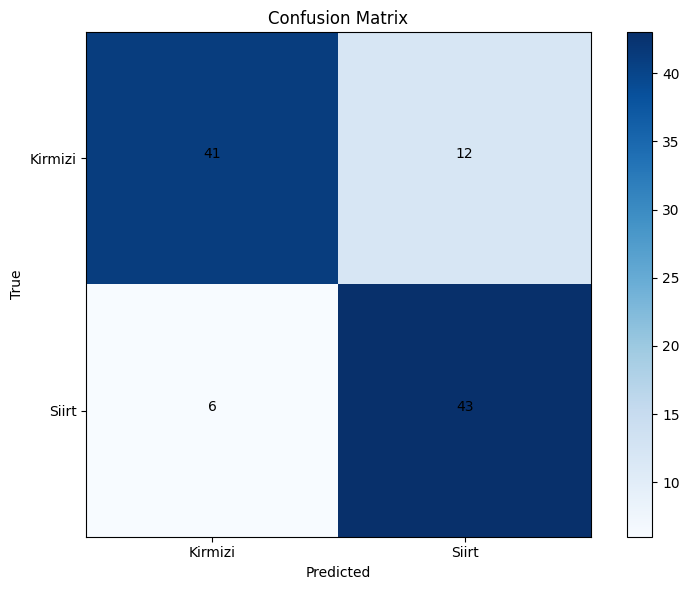

In [10]:
# Import library
import requests, zipfile, shutil, os
requests.packages.urllib3.disable_warnings()
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Define the URL to download the dataset #https://www.muratkoklu.com/datasets/
dataset_url = "https://www.muratkoklu.com/datasets/vtdhnd12.php"

# Download the dataset to a temporary file
response = requests.get(dataset_url)
with open("pistachio_dataset.zip", "wb") as f:
    f.write(response.content)

# Extract the dataset from the ZIP file
with zipfile.ZipFile("pistachio_dataset.zip", "r") as zip_ref:
    zip_ref.extractall()

# Delete the temporary ZIP file
os.remove("pistachio_dataset.zip")

# Define the source directories for the downloaded images
kirmizi_dir = "./Pistachio_Image_Dataset/Pistachio_Image_Dataset/Kirmizi_Pistachio/"
siirt_dir = "./Pistachio_Image_Dataset/Pistachio_Image_Dataset/Siirt_Pistachio/"


# Define the directories for train, test, and validation sets for both categories
train_dir_kirmizi = "./Pistachio_Image_Dataset/Pistachio_Image_Dataset/train/kirmizi"
test_dir_kirmizi = "./Pistachio_Image_Dataset/Pistachio_Image_Dataset/test/kirmizi"
validation_dir_kirmizi = "./Pistachio_Image_Dataset/Pistachio_Image_Dataset/validation/kirmizi"

train_dir_siirt = "./Pistachio_Image_Dataset/Pistachio_Image_Dataset/train/siirt"
test_dir_siirt = "./Pistachio_Image_Dataset/Pistachio_Image_Dataset/test/siirt"
validation_dir_siirt = "./Pistachio_Image_Dataset/Pistachio_Image_Dataset/validation/siirt"


# Create directories for train, test, and validation sets for both categories
for directory in [train_dir_kirmizi, test_dir_kirmizi, validation_dir_kirmizi,
                  train_dir_siirt, test_dir_siirt, validation_dir_siirt]:
    if not os.path.exists(directory):
        os.makedirs(directory)

# Define the number of images to copy for each set
train_images = 70
test_images = 10
validation_images = 20

# Copy Kirmizi images
kirmizi_image_files = os.listdir(kirmizi_dir)
np.random.shuffle(kirmizi_image_files)

# Train set
for i in range(train_images):
    source_path = os.path.join(kirmizi_dir, kirmizi_image_files[i])
    destination_path = os.path.join("./Pistachio_Image_Dataset/Pistachio_Image_Dataset/train/kirmizi/", kirmizi_image_files[i])
    shutil.copy2(source_path, destination_path)

# Test set
for i in range(train_images, train_images + test_images):
    source_path = os.path.join(kirmizi_dir, kirmizi_image_files[i])
    destination_path = os.path.join("./Pistachio_Image_Dataset/Pistachio_Image_Dataset/test/kirmizi/", kirmizi_image_files[i])
    shutil.copy2(source_path, destination_path)

# Validation set
for i in range(train_images + test_images, train_images + test_images + validation_images):
    source_path = os.path.join(kirmizi_dir, kirmizi_image_files[i])
    destination_path = os.path.join("./Pistachio_Image_Dataset/Pistachio_Image_Dataset/validation/kirmizi/", kirmizi_image_files[i])
    shutil.copy2(source_path, destination_path)

# Copy Siirt images
siirt_image_files = os.listdir(siirt_dir)
np.random.shuffle(siirt_image_files)

# Train set
for i in range(train_images):
    source_path = os.path.join(siirt_dir, siirt_image_files[i])
    destination_path = os.path.join("./Pistachio_Image_Dataset/Pistachio_Image_Dataset/train/siirt/", siirt_image_files[i])
    shutil.copy2(source_path, destination_path)

# Test set
for i in range(train_images, train_images + test_images):
    source_path = os.path.join(siirt_dir, siirt_image_files[i])
    destination_path = os.path.join("./Pistachio_Image_Dataset/Pistachio_Image_Dataset/test/siirt/", siirt_image_files[i])
    shutil.copy2(source_path, destination_path)

# Validation set
for i in range(train_images + test_images, train_images + test_images + validation_images):
    source_path = os.path.join(siirt_dir, siirt_image_files[i])
    destination_path = os.path.join("./Pistachio_Image_Dataset/Pistachio_Image_Dataset/validation/siirt/", siirt_image_files[i])
    shutil.copy2(source_path, destination_path)

# Define the path to the downloaded dataset
train_dir = "./Pistachio_Image_Dataset/Pistachio_Image_Dataset/train/"
test_dir = "./Pistachio_Image_Dataset/Pistachio_Image_Dataset/test/"
validation_dir = "./Pistachio_Image_Dataset/Pistachio_Image_Dataset/validation/"

# # Iterate over the Kirmizi images and add them to the arrays
# for filename in os.listdir(kirmizi_dir):
#     image = Image.open(os.path.join(kirmizi_dir, filename))
#     image = image.resize((128, 128))  # Resize the image to 128x128
#     image = np.array(image) / 255.0  # Normalize pixel values to range [0, 1]
#     images.append(image)
#     labels.append(0)  # Label Kirmizi as 0

# # Iterate over the Siirt images and add them to the arrays
# for filename in os.listdir(siirt_dir):
#     image = Image.open(os.path.join(siirt_dir, filename))
#     image = image.resize((128, 128))  # Resize the image to 128x128
#     image = np.array(image) / 255.0  # Normalize pixel values to range [0, 1]
#     images.append(image)
#     labels.append(1)  # Label Siirt as 1

# Initialize empty NumPy arrays to store the image data and labels
images = []
labels = []

# Iterate over the Kirmizi images and add them to the arrays
for filename in os.listdir(train_dir_kirmizi):
    image = Image.open(os.path.join(train_dir_kirmizi, filename))
    image = image.resize((128, 128))  # Resize the image to 128x128
    image = np.array(image) / 255.0  # Normalize pixel values to range [0, 1]
    images.append(image)
    labels.append(0)  # Label Kirmizi as 0

# Iterate over the Siirt images and add them to the arrays
for filename in os.listdir(train_dir_siirt):
    image = Image.open(os.path.join(train_dir_siirt, filename))
    image = image.resize((128, 128))  # Resize the image to 128x128
    image = np.array(image) / 255.0  # Normalize pixel values to range [0, 1]
    images.append(image)
    labels.append(1)  # Label Siirt as 1

# # Iterate over the Kirmizi images and add them to the arrays
# for filename in os.listdir(train_dir_kirmizi):
#     image = Image.open(os.path.join(train_dir_kirmizi, filename))
#     images.append(np.array(image))
#     labels.append(0)  # Label Kirmizi as 0

# # Iterate over the Siirt images and add them to the arrays
# for filename in os.listdir(train_dir_siirt):
#     image = Image.open(os.path.join(train_dir_siirt, filename))
#     images.append(np.array(image))
#     labels.append(1)  # Label Siirt as 1
# Convert the lists to NumPy arrays
images = np.array(images)
labels = np.array(labels)

# Print the shapes of the image and labels arrays
print("Images shape:", images.shape)
print("Labels shape:", labels.shape)

# Split the data into training and testing sets
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

# Print the shapes of the training and testing sets
print("Training images shape:", train_images.shape)
print("Training labels shape:", train_labels.shape)
print("Testing images shape:", test_images.shape)
print("Testing labels shape:", test_labels.shape)

from sklearn.svm import SVC

# Create and train SVM classifier
svm_classifier = SVC(kernel='rbf', C=1.0)
svm_classifier.fit(train_images.reshape(len(train_images), -1), train_labels)

from sklearn.metrics import accuracy_score

# Predict labels on the testing set
test_predictions = svm_classifier.predict(test_images.reshape(len(test_images), -1))

# Calculate accuracy
test_accuracy = accuracy_score(test_labels, test_predictions)
print('Test Accuracy:', test_accuracy)

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Create and train SVM classifier
svm_classifier = SVC(kernel='rbf', C=1.0)
svm_classifier.fit(train_images.reshape(len(train_images), -1), train_labels)

# Predict labels on the testing set
test_predictions = svm_classifier.predict(test_images.reshape(len(test_images), -1))

# Calculate accuracy
test_accuracy = accuracy_score(test_labels, test_predictions)
print('Test Accuracy:', test_accuracy)

# Calculate confusion matrix
conf_matrix = confusion_matrix(test_labels, test_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

classes = ['Kirmizi', 'Siirt']
tick_marks = np.arange(len(classes))

plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, str(conf_matrix[i][j]), horizontalalignment='center', color='black')

plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()